In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import random
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=True)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16
learning_rate = 0.001
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

transforms = transforms.Compose([
    transforms.Resize(48),
    transforms.CenterCrop(48),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4927, 0.4927, 0.4927], std=[0.4999, 0.4999, 0.4999]),
])
train_dataset = datasets.ImageFolder(root='emotion3/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion3/test/', transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.4927, 0.4927, 0.4927])
    std = np.array([0.4999, 0.4999, 0.4999])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 48, 48])
out-size: torch.Size([3, 102, 402])


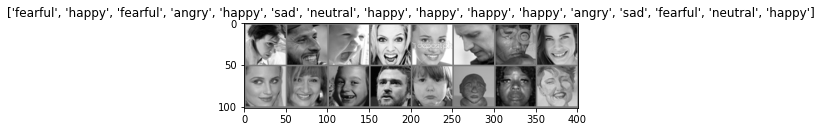

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.001_adam_batch16_epoch30.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/1248], Loss: 8.4473
Epoch [1/30], Step [20/1248], Loss: 1.8856
Epoch [1/30], Step [40/1248], Loss: 2.0104
Epoch [1/30], Step [60/1248], Loss: 1.7570
Epoch [1/30], Step [80/1248], Loss: 1.6819
Epoch [1/30], Step [100/1248], Loss: 1.5480
Epoch [1/30], Step [120/1248], Loss: 1.6512
Epoch [1/30], Step [140/1248], Loss: 1.5962
Epoch [1/30], Step [160/1248], Loss: 1.4222
Epoch [1/30], Step [180/1248], Loss: 1.8122
Epoch [1/30], Step [200/1248], Loss: 1.4086
Epoch [1/30], Step [220/1248], Loss: 1.8064
Epoch [1/30], Step [240/1248], Loss: 1.6631
Epoch [1/30], Step [260/1248], Loss: 0.7959
Epoch [1/30], Step [280/1248], Loss: 1.2240
Epoch [1/30], Step [300/1248], Loss: 1.1326
Epoch [1/30], Step [320/1248], Loss: 1.4195
Epoch [1/30], Step [340/1248], Loss: 1.4172
Epoch [1/30], Step [360/1248], Loss: 1.4219
Epoch [1/30], Step [380/1248], Loss: 1.4005
Epoch [1/30], Step [400/1248], Loss: 1.5754
Epoch [1/30], Step [420/1248], Loss: 1.7834
Epoch [1/30], Step [440/1248]

Epoch [3/30], Step [1080/1248], Loss: 1.3677
Epoch [3/30], Step [1100/1248], Loss: 1.2116
Epoch [3/30], Step [1120/1248], Loss: 0.8000
Epoch [3/30], Step [1140/1248], Loss: 0.7405
Epoch [3/30], Step [1160/1248], Loss: 0.8989
Epoch [3/30], Step [1180/1248], Loss: 0.8584
Epoch [3/30], Step [1200/1248], Loss: 1.3033
Epoch [3/30], Step [1220/1248], Loss: 0.7188
Epoch [3/30], Step [1240/1248], Loss: 1.2948

train-loss: 1.2272, train-acc: 60.8667
validation loss: 1.0763, validation acc: 61.7729

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/1248], Loss: 0.6728
Epoch [4/30], Step [20/1248], Loss: 0.8494
Epoch [4/30], Step [40/1248], Loss: 0.8865
Epoch [4/30], Step [60/1248], Loss: 0.7105
Epoch [4/30], Step [80/1248], Loss: 0.8496
Epoch [4/30], Step [100/1248], Loss: 1.2102
Epoch [4/30], Step [120/1248], Loss: 1.2706
Epoch [4/30], Step [140/1248], Loss: 1.2793
Epoch [4/30], Step [160/1248], Loss: 0.9619
Epoch [4/30], Step [180/1248], Loss: 1.1945
Epoch [4/30], Step [200/1248]

Epoch [6/30], Step [860/1248], Loss: 0.5996
Epoch [6/30], Step [880/1248], Loss: 1.0368
Epoch [6/30], Step [900/1248], Loss: 1.1177
Epoch [6/30], Step [920/1248], Loss: 0.3156
Epoch [6/30], Step [940/1248], Loss: 0.6268
Epoch [6/30], Step [960/1248], Loss: 0.4407
Epoch [6/30], Step [980/1248], Loss: 0.7204
Epoch [6/30], Step [1000/1248], Loss: 0.3852
Epoch [6/30], Step [1020/1248], Loss: 0.6214
Epoch [6/30], Step [1040/1248], Loss: 0.7246
Epoch [6/30], Step [1060/1248], Loss: 0.4280
Epoch [6/30], Step [1080/1248], Loss: 2.0388
Epoch [6/30], Step [1100/1248], Loss: 0.6975
Epoch [6/30], Step [1120/1248], Loss: 0.9302
Epoch [6/30], Step [1140/1248], Loss: 0.7119
Epoch [6/30], Step [1160/1248], Loss: 0.5923
Epoch [6/30], Step [1180/1248], Loss: 0.9966
Epoch [6/30], Step [1200/1248], Loss: 0.9357
Epoch [6/30], Step [1220/1248], Loss: 0.6061
Epoch [6/30], Step [1240/1248], Loss: 0.4399

train-loss: 1.0091, train-acc: 75.8317
validation loss: 1.0642, validation acc: 64.0364

Epoch 7

Epoch [7

Epoch [9/30], Step [660/1248], Loss: 0.0674
Epoch [9/30], Step [680/1248], Loss: 0.2336
Epoch [9/30], Step [700/1248], Loss: 0.1674
Epoch [9/30], Step [720/1248], Loss: 0.0567
Epoch [9/30], Step [740/1248], Loss: 0.5291
Epoch [9/30], Step [760/1248], Loss: 0.1424
Epoch [9/30], Step [780/1248], Loss: 0.3733
Epoch [9/30], Step [800/1248], Loss: 0.3468
Epoch [9/30], Step [820/1248], Loss: 0.2723
Epoch [9/30], Step [840/1248], Loss: 0.7794
Epoch [9/30], Step [860/1248], Loss: 0.1162
Epoch [9/30], Step [880/1248], Loss: 0.3944
Epoch [9/30], Step [900/1248], Loss: 0.2896
Epoch [9/30], Step [920/1248], Loss: 0.3285
Epoch [9/30], Step [940/1248], Loss: 0.4484
Epoch [9/30], Step [960/1248], Loss: 0.4615
Epoch [9/30], Step [980/1248], Loss: 0.2104
Epoch [9/30], Step [1000/1248], Loss: 0.1422
Epoch [9/30], Step [1020/1248], Loss: 0.4450
Epoch [9/30], Step [1040/1248], Loss: 0.1308
Epoch [9/30], Step [1060/1248], Loss: 0.2702
Epoch [9/30], Step [1080/1248], Loss: 0.1014
Epoch [9/30], Step [1100/12

Epoch [12/30], Step [400/1248], Loss: 0.0718
Epoch [12/30], Step [420/1248], Loss: 0.0313
Epoch [12/30], Step [440/1248], Loss: 0.0678
Epoch [12/30], Step [460/1248], Loss: 0.0931
Epoch [12/30], Step [480/1248], Loss: 0.1033
Epoch [12/30], Step [500/1248], Loss: 0.0720
Epoch [12/30], Step [520/1248], Loss: 0.1880
Epoch [12/30], Step [540/1248], Loss: 0.1620
Epoch [12/30], Step [560/1248], Loss: 0.0598
Epoch [12/30], Step [580/1248], Loss: 0.0134
Epoch [12/30], Step [600/1248], Loss: 0.2179
Epoch [12/30], Step [620/1248], Loss: 0.0839
Epoch [12/30], Step [640/1248], Loss: 0.0217
Epoch [12/30], Step [660/1248], Loss: 0.0403
Epoch [12/30], Step [680/1248], Loss: 0.0219
Epoch [12/30], Step [700/1248], Loss: 0.3295
Epoch [12/30], Step [720/1248], Loss: 0.0906
Epoch [12/30], Step [740/1248], Loss: 0.0343
Epoch [12/30], Step [760/1248], Loss: 0.0702
Epoch [12/30], Step [780/1248], Loss: 0.1331
Epoch [12/30], Step [800/1248], Loss: 0.0947
Epoch [12/30], Step [820/1248], Loss: 0.3276
Epoch [12/

Epoch [15/30], Step [120/1248], Loss: 0.1163
Epoch [15/30], Step [140/1248], Loss: 0.0196
Epoch [15/30], Step [160/1248], Loss: 0.0532
Epoch [15/30], Step [180/1248], Loss: 0.2165
Epoch [15/30], Step [200/1248], Loss: 0.0095
Epoch [15/30], Step [220/1248], Loss: 0.0490
Epoch [15/30], Step [240/1248], Loss: 0.0448
Epoch [15/30], Step [260/1248], Loss: 0.3002
Epoch [15/30], Step [280/1248], Loss: 0.1135
Epoch [15/30], Step [300/1248], Loss: 0.0486
Epoch [15/30], Step [320/1248], Loss: 0.0417
Epoch [15/30], Step [340/1248], Loss: 0.0231
Epoch [15/30], Step [360/1248], Loss: 0.0103
Epoch [15/30], Step [380/1248], Loss: 0.0334
Epoch [15/30], Step [400/1248], Loss: 0.2403
Epoch [15/30], Step [420/1248], Loss: 0.2250
Epoch [15/30], Step [440/1248], Loss: 0.3076
Epoch [15/30], Step [460/1248], Loss: 0.1245
Epoch [15/30], Step [480/1248], Loss: 0.0181
Epoch [15/30], Step [500/1248], Loss: 0.2259
Epoch [15/30], Step [520/1248], Loss: 0.0458
Epoch [15/30], Step [540/1248], Loss: 0.0374
Epoch [15/

Epoch [17/30], Step [1160/1248], Loss: 0.0606
Epoch [17/30], Step [1180/1248], Loss: 0.0146
Epoch [17/30], Step [1200/1248], Loss: 0.0886
Epoch [17/30], Step [1220/1248], Loss: 0.0697
Epoch [17/30], Step [1240/1248], Loss: 0.2869

train-loss: 0.5080, train-acc: 95.8567
validation loss: 1.3779, validation acc: 62.7972

Epoch 18

Epoch [18/30], Step [0/1248], Loss: 0.1517
Epoch [18/30], Step [20/1248], Loss: 0.0251
Epoch [18/30], Step [40/1248], Loss: 0.2239
Epoch [18/30], Step [60/1248], Loss: 0.0385
Epoch [18/30], Step [80/1248], Loss: 0.0818
Epoch [18/30], Step [100/1248], Loss: 0.0416
Epoch [18/30], Step [120/1248], Loss: 0.1318
Epoch [18/30], Step [140/1248], Loss: 0.1200
Epoch [18/30], Step [160/1248], Loss: 0.0077
Epoch [18/30], Step [180/1248], Loss: 0.1371
Epoch [18/30], Step [200/1248], Loss: 0.0731
Epoch [18/30], Step [220/1248], Loss: 0.2851
Epoch [18/30], Step [240/1248], Loss: 0.0187
Epoch [18/30], Step [260/1248], Loss: 0.0065
Epoch [18/30], Step [280/1248], Loss: 0.1608
E

Epoch [20/30], Step [900/1248], Loss: 0.0213
Epoch [20/30], Step [920/1248], Loss: 0.0194
Epoch [20/30], Step [940/1248], Loss: 0.3676
Epoch [20/30], Step [960/1248], Loss: 0.3837
Epoch [20/30], Step [980/1248], Loss: 0.1100
Epoch [20/30], Step [1000/1248], Loss: 1.0461
Epoch [20/30], Step [1020/1248], Loss: 0.0678
Epoch [20/30], Step [1040/1248], Loss: 0.5235
Epoch [20/30], Step [1060/1248], Loss: 0.0494
Epoch [20/30], Step [1080/1248], Loss: 0.0497
Epoch [20/30], Step [1100/1248], Loss: 0.2862
Epoch [20/30], Step [1120/1248], Loss: 0.0648
Epoch [20/30], Step [1140/1248], Loss: 0.0407
Epoch [20/30], Step [1160/1248], Loss: 0.2896
Epoch [20/30], Step [1180/1248], Loss: 0.0496
Epoch [20/30], Step [1200/1248], Loss: 0.0971
Epoch [20/30], Step [1220/1248], Loss: 0.0595
Epoch [20/30], Step [1240/1248], Loss: 0.2349

train-loss: 0.4497, train-acc: 95.6062
validation loss: 1.4188, validation acc: 63.3915

Epoch 21

Epoch [21/30], Step [0/1248], Loss: 0.0848
Epoch [21/30], Step [20/1248], Los

Epoch [23/30], Step [620/1248], Loss: 0.0045
Epoch [23/30], Step [640/1248], Loss: 0.0058
Epoch [23/30], Step [660/1248], Loss: 0.0055
Epoch [23/30], Step [680/1248], Loss: 0.0100
Epoch [23/30], Step [700/1248], Loss: 0.0543
Epoch [23/30], Step [720/1248], Loss: 0.0541
Epoch [23/30], Step [740/1248], Loss: 0.0009
Epoch [23/30], Step [760/1248], Loss: 0.0067
Epoch [23/30], Step [780/1248], Loss: 0.1042
Epoch [23/30], Step [800/1248], Loss: 0.1203
Epoch [23/30], Step [820/1248], Loss: 0.1675
Epoch [23/30], Step [840/1248], Loss: 0.1351
Epoch [23/30], Step [860/1248], Loss: 0.0972
Epoch [23/30], Step [880/1248], Loss: 0.0162
Epoch [23/30], Step [900/1248], Loss: 0.0097
Epoch [23/30], Step [920/1248], Loss: 0.0400
Epoch [23/30], Step [940/1248], Loss: 0.0454
Epoch [23/30], Step [960/1248], Loss: 0.2317
Epoch [23/30], Step [980/1248], Loss: 0.0127
Epoch [23/30], Step [1000/1248], Loss: 0.0459
Epoch [23/30], Step [1020/1248], Loss: 0.0270
Epoch [23/30], Step [1040/1248], Loss: 0.0400
Epoch [

Epoch [26/30], Step [340/1248], Loss: 0.0534
Epoch [26/30], Step [360/1248], Loss: 0.0079
Epoch [26/30], Step [380/1248], Loss: 0.0135
Epoch [26/30], Step [400/1248], Loss: 0.3968
Epoch [26/30], Step [420/1248], Loss: 0.0030
Epoch [26/30], Step [440/1248], Loss: 0.0450
Epoch [26/30], Step [460/1248], Loss: 0.1470
Epoch [26/30], Step [480/1248], Loss: 0.2331
Epoch [26/30], Step [500/1248], Loss: 0.0643
Epoch [26/30], Step [520/1248], Loss: 0.0282
Epoch [26/30], Step [540/1248], Loss: 0.0232
Epoch [26/30], Step [560/1248], Loss: 0.0050
Epoch [26/30], Step [580/1248], Loss: 0.0264
Epoch [26/30], Step [600/1248], Loss: 0.0034
Epoch [26/30], Step [620/1248], Loss: 0.0304
Epoch [26/30], Step [640/1248], Loss: 0.1476
Epoch [26/30], Step [660/1248], Loss: 0.0107
Epoch [26/30], Step [680/1248], Loss: 0.0040
Epoch [26/30], Step [700/1248], Loss: 0.0317
Epoch [26/30], Step [720/1248], Loss: 0.0603
Epoch [26/30], Step [740/1248], Loss: 0.0077
Epoch [26/30], Step [760/1248], Loss: 0.0111
Epoch [26/

Epoch [29/30], Step [60/1248], Loss: 0.0412
Epoch [29/30], Step [80/1248], Loss: 0.0309
Epoch [29/30], Step [100/1248], Loss: 0.1539
Epoch [29/30], Step [120/1248], Loss: 0.0024
Epoch [29/30], Step [140/1248], Loss: 0.0556
Epoch [29/30], Step [160/1248], Loss: 0.0024
Epoch [29/30], Step [180/1248], Loss: 0.1606
Epoch [29/30], Step [200/1248], Loss: 0.0061
Epoch [29/30], Step [220/1248], Loss: 0.0138
Epoch [29/30], Step [240/1248], Loss: 0.0458
Epoch [29/30], Step [260/1248], Loss: 0.0077
Epoch [29/30], Step [280/1248], Loss: 0.0036
Epoch [29/30], Step [300/1248], Loss: 0.1461
Epoch [29/30], Step [320/1248], Loss: 0.0055
Epoch [29/30], Step [340/1248], Loss: 0.0097
Epoch [29/30], Step [360/1248], Loss: 0.0019
Epoch [29/30], Step [380/1248], Loss: 0.0052
Epoch [29/30], Step [400/1248], Loss: 0.0067
Epoch [29/30], Step [420/1248], Loss: 0.0368
Epoch [29/30], Step [440/1248], Loss: 0.0600
Epoch [29/30], Step [460/1248], Loss: 0.0127
Epoch [29/30], Step [480/1248], Loss: 0.0024
Epoch [29/30

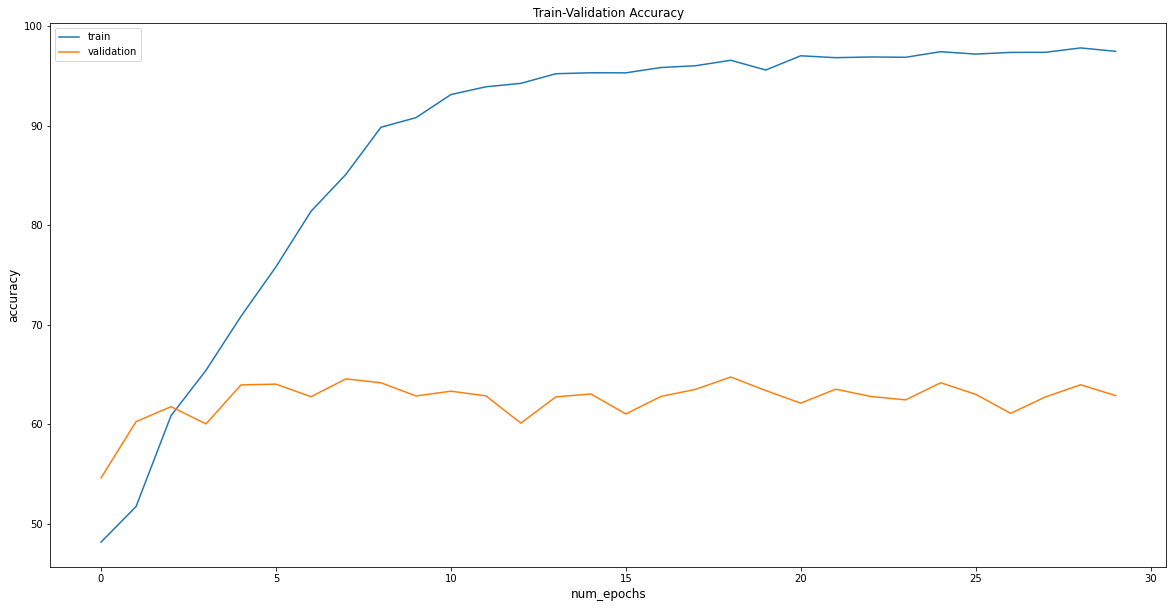

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

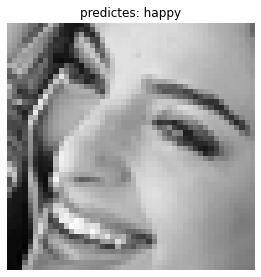

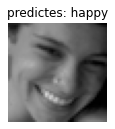

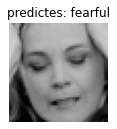

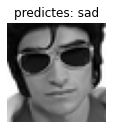

In [10]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()